# Forest management problem

In [54]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

from desdeo_problem.problem import DiscreteDataProblem
from desdeo_tools.scalarization import SimpleASF, DiscreteScalarizer, StomASF, PointMethodASF
from desdeo_tools.solver import DiscreteMinimizer
from shapley_values.explanations import *
from shapley_values.utilities import *
from IPython.core.display import display, HTML

# parameters
## the ASF used
ASF = PointMethodASF

# Load and setup problem (all objectives are defined to be maximized, so we multiply the whole dataframe by -1)
df = -1*pd.read_csv("../data/forest.csv")
pareto_front = df.to_numpy()

# compute the ideal and nadir
ideal = np.min(pareto_front[:, 0:3], axis=0)
nadir = np.max(pareto_front[:, 0:3], axis=0)

objective_names = ["Income", "Carbon", "Habitat index"]
n_objectives = 3

# we do not know the original decision variables, so we use a single 'dummy' variable just to make sure DiscreteDataProblem works correctly with the data
problem = DiscreteDataProblem(df, "dummy", objective_names, nadir, ideal)

asf = ASF(nadir, ideal)

# sample the Pareto front for missing data to be used while computing SHAP values
missing_data = shap.sample(pareto_front[:, 0:n_objectives], nsamples=200)

# generate the method to be used, or the black-box
bb = generate_black_box(problem, asf)

# define the explainer that computed SHAP values (use kernel SHAP)
explainer = shap.KernelExplainer(bb, missing_data)

def scale_forest_data(data):
    multipliers = np.array([1e-7, 1e-9, 1e-4])
    return multipliers * data

def plot(result, objective_names=["Income (10^7)", "Carbon (10^9)", "Habitat index (10^4)"], ymin=0, ymax=1):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.set_ylim(ymin, ymax)
    ax.bar(objective_names, np.squeeze(result)) 
    plt.grid()
    plt.show()
    
print(f"Ideal: {-ideal}")
print(f"Nadir: {-nadir}")

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Ideal: [6.28549125e+07 8.26913286e+09 3.24361169e+04]
Nadir: [1.87693838e+07 6.73323709e+09 2.13938867e+04]


Reference point: [-4.08121481e+07 -7.50118497e+09 -2.69150018e+04]
Projection: [[-4.69889797e+07 -7.74019668e+09 -2.83623684e+04]]


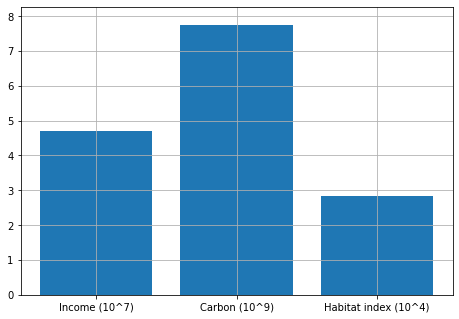

In [56]:
ref_point = (ideal + nadir) / 2.0

projection = bb(np.atleast_2d(ref_point))
shap_values = np.array(explainer.shap_values(ref_point))

print(f"Reference point: {ref_point}")
print(f"Projection: {projection}")

plot(-scale_forest_data(projection), ymax=np.max(-scale_forest_data(ideal)))

In [58]:
to_improve = 0
suggestion_str, _, _, _ = how_to_improve_objective_i(shap_values, to_improve, ref_point, projection)

display(HTML(f"<p style=font-size:20px>{suggestion_str}</p>"))